In [1]:
import cv2,os,math
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 00. Read image

In [3]:
train_path = "../Datasets/DefectDetect/casting_512x512/casting_512x512/"
test_path = "../Datasets/DefectDetect/casting_data/casting_data/test/"

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((100, 100)),])
#                                transforms.Grayscale(num_output_channels=1)],
train_dataset = datasets.ImageFolder(train_path, transform)
test_dataset  = datasets.ImageFolder(test_path, transform)

In [5]:
batch_size = 128

# train_size = int(0.8*len(train_dataset))
# val_size = len(train_dataset)-train_size

# train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
print("Total number of train : ", len(train_dataset))
print("Total number of val : ", len(test_dataset))
print("Total number of test : ", len(test_dataset))

Total number of train :  1300
Total number of val :  715
Total number of test :  715


# 01. Build model

In [7]:
class Feactor(nn.Module):
    def __init__(self, image_size):
        super(Feactor,self).__init__()
        self.image_size = image_size
        
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
            nn.ReLU(),
        )
        self.residual_layer = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
        )
        self.last_layer = nn.Sequential(
            nn.Conv2d(64,2,kernel_size=100,stride=1,padding=0),
            nn.Flatten(),
        )

    def forward(self, input_image):
        pre = self.pre_layer(input_image)
        res = self.residual_layer(pre)
        last = self.last_layer(res)
        return last
    
class ResidualBlock(nn.Module):
    def __init__(self, input_channel):
        super(ResidualBlock,self).__init__()
        self.residualblock = nn.Sequential(
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
        )
    def forward(self, x):
        residual = self.residualblock(x)
        return x + residual

In [8]:
model = torch.load("def_allweight_220927.pkl")

In [93]:
# model = models.resnet18(pretrained=True)

# model.layer3 = nn.Sequential()
# model.layer4 = nn.Sequential()

# model.fc = nn.Sequential(
#     nn.Linear(128, 2))

In [9]:
ngpu = 1
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

In [10]:
image_size = 100
model = Feactor(image_size).to(device)
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model(test_input).shape)

torch.Size([1, 2])


In [96]:
# #Freeze model weights
# for param in model.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True

## 1.1 Define loss and optimizer

In [11]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略

## 1.2 Train model

In [92]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

In [93]:
n_epochs = 10
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == y).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == y).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_valid))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 3250.002, Accuracy: 0.535], Valid [Loss: 2478.826, Accuracy: 0.634]
EPOCH: 1, Train [Loss: 646.713, Accuracy: 0.498], Valid [Loss: 144.850, Accuracy: 0.634]
EPOCH: 2, Train [Loss: 410.023, Accuracy: 0.535], Valid [Loss: 2274.314, Accuracy: 0.366]
EPOCH: 3, Train [Loss: 289.279, Accuracy: 0.541], Valid [Loss: 2870.083, Accuracy: 0.366]
EPOCH: 4, Train [Loss: 2298.263, Accuracy: 0.512], Valid [Loss: 31.748, Accuracy: 0.634]
EPOCH: 5, Train [Loss: 2691.514, Accuracy: 0.507], Valid [Loss: 215.103, Accuracy: 0.366]
EPOCH: 6, Train [Loss: 1970.268, Accuracy: 0.553], Valid [Loss: 2450.580, Accuracy: 0.366]
EPOCH: 7, Train [Loss: 3637.921, Accuracy: 0.476], Valid [Loss: 830.809, Accuracy: 0.366]
EPOCH: 8, Train [Loss: 372.779, Accuracy: 0.548], Valid [Loss: 398.130, Accuracy: 0.634]
EPOCH: 9, Train [Loss: 670.403, Accuracy: 0.539], Valid [Loss: 221.322, Accuracy: 0.634]


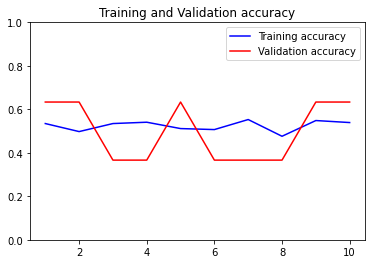

<Figure size 432x288 with 0 Axes>

In [94]:
# train processing plot
n_epochs = 10
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# 02. Visualize weight

In [15]:
params = list(model.parameters())
for i in range(len(params)):
    print(i, params[i].size())

0 torch.Size([64, 3, 9, 9])
1 torch.Size([64])
2 torch.Size([64, 64, 3, 3])
3 torch.Size([64])
4 torch.Size([64])
5 torch.Size([64])
6 torch.Size([64, 64, 3, 3])
7 torch.Size([64])
8 torch.Size([64])
9 torch.Size([64])
10 torch.Size([64, 64, 3, 3])
11 torch.Size([64])
12 torch.Size([64])
13 torch.Size([64])
14 torch.Size([64, 64, 3, 3])
15 torch.Size([64])
16 torch.Size([64])
17 torch.Size([64])
18 torch.Size([64, 64, 3, 3])
19 torch.Size([64])
20 torch.Size([64])
21 torch.Size([64])
22 torch.Size([64, 64, 3, 3])
23 torch.Size([64])
24 torch.Size([64])
25 torch.Size([64])
26 torch.Size([2, 64, 100, 100])
27 torch.Size([2])


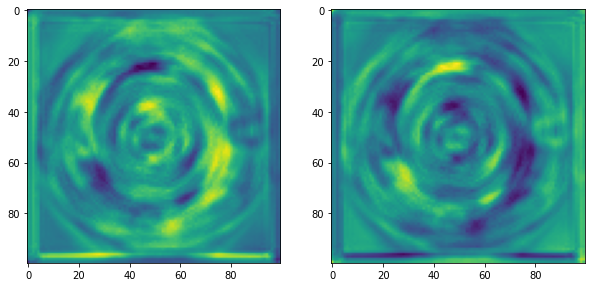

In [51]:
params_last = params[26].detach().cpu()
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(params_last[0].permute(1,2,0).mean(dim=2))
plt.subplot(1,2,2)
plt.imshow(params_last[1].permute(1,2,0).mean(dim=2))

# 03. Visualize feature map

In [17]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))

In [18]:
i=100
img = train_dataset[i][0].permute(1,2,0).numpy()
label = train_dataset[i][1]
input_tensor = train_dataset[i][0].unsqueeze(0).to(device)
output = model(input_tensor)
y = output.argmax(1).cpu().item()
print(label , y==label)

0 True


In [ ]:
# mean feature map
key = "residual_layer"

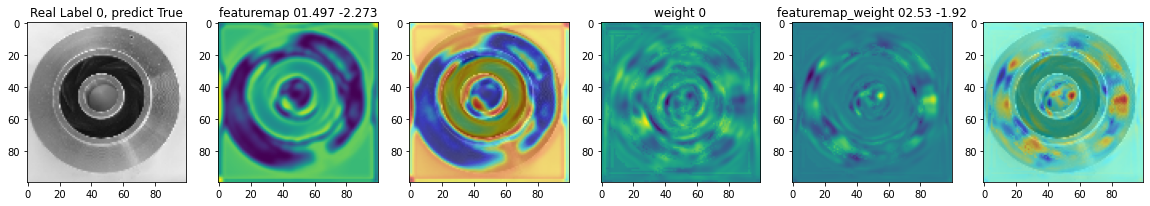

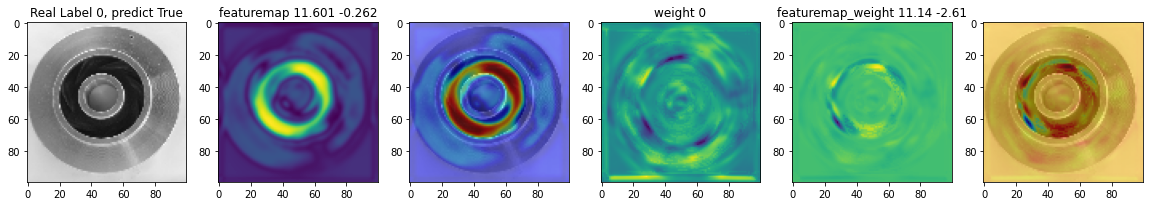

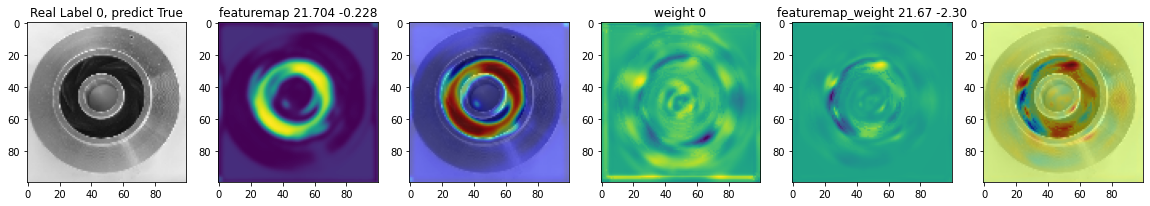

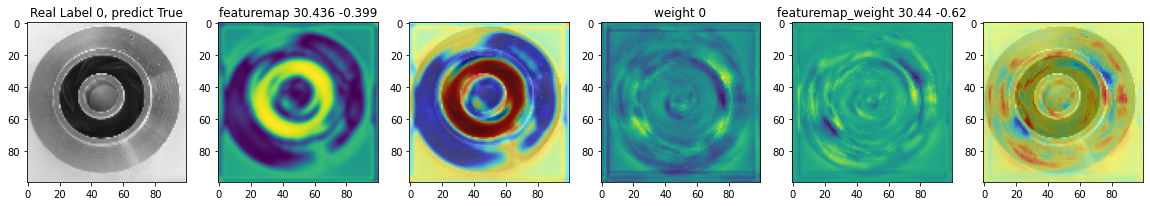

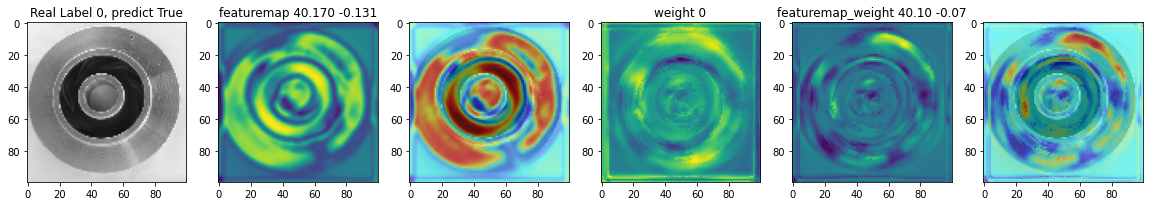

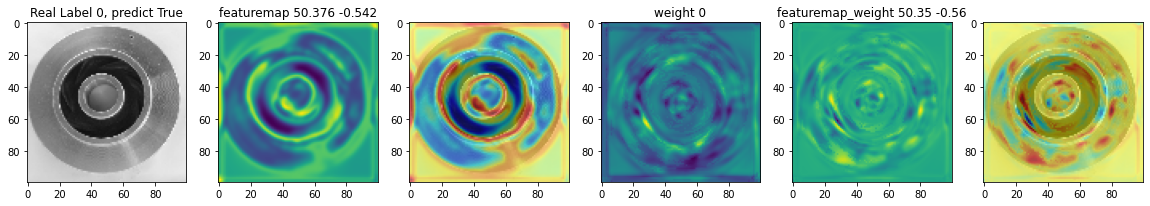

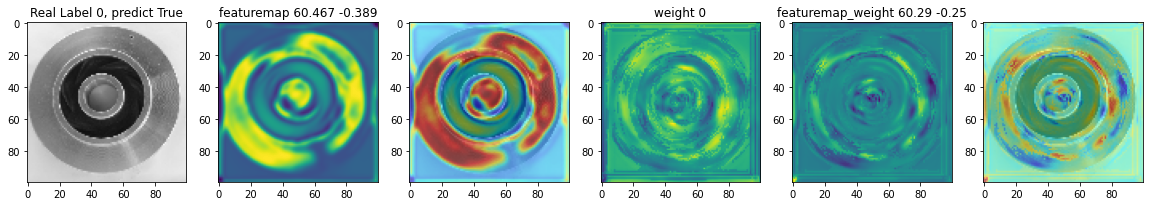

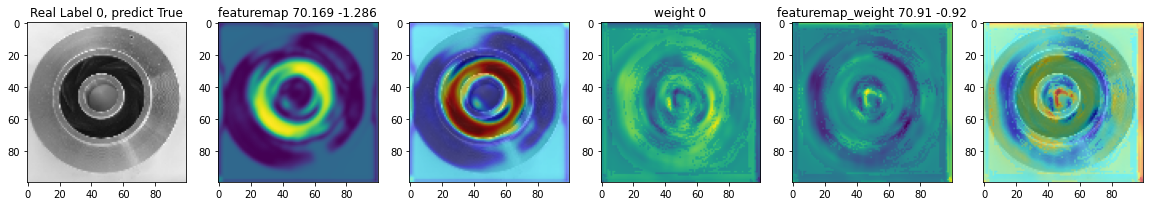

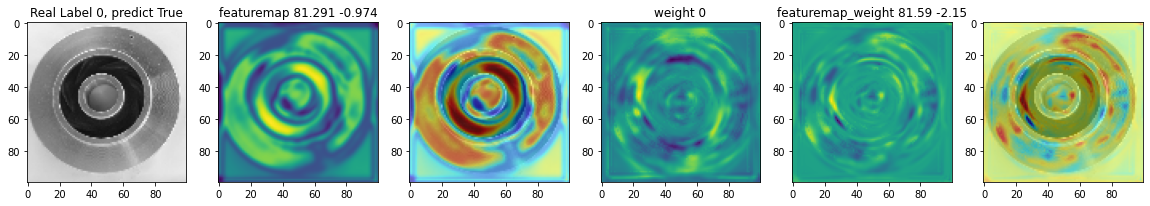

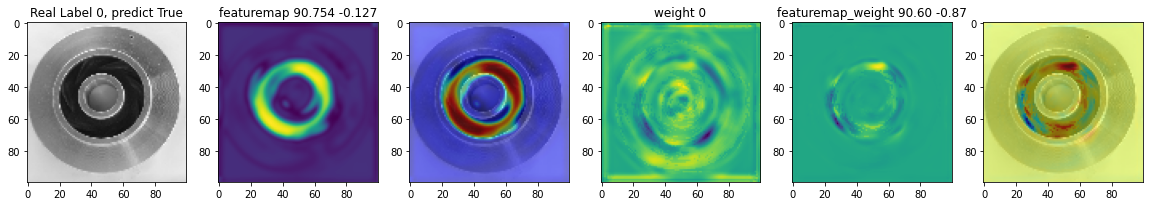

In [71]:
# weight feature map
for i in range(10):
    plt.figure(figsize=(20,20))
    plt.subplot(1,6,1)
    plt.title("Real Label "+str(label)+", predict "+str(y==label))
    plt.imshow(img/np.amax(img))
    
    bn = feature_activation[key].cpu()[0][i].numpy()
    plt.subplot(1,6,2)
    plt.title("featuremap "+str(i)+str(format(np.amax(bn),'.3f'))+" "+str(format(np.amin(bn),'.3f')))
    plt.imshow(bn)
    
    bn_norm = cv2.normalize(bn, None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
    cam = show_cam_on_image(img, bn_norm, use_rgb=True)
    plt.subplot(1,6,3)
    plt.imshow(cam)
    
    weight = params_last[label][i].numpy()
    plt.subplot(1,6,4)
    plt.title("weight "+str(label))
    plt.imshow(weight)
    
    bn_weight = cv2.multiply(bn, weight)
    plt.subplot(1,6,5)
    plt.title("featuremap_weight "+str(i)+str(format(np.amax(bn_weight),'.2f'))+" "+str(format(np.amin(bn_weight),'.2f')))
    plt.imshow(bn_weight)
    
    bn_weight_norm = cv2.normalize(bn_weight, None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
    cam = show_cam_on_image(img, bn_weight_norm, use_rgb=True)
    plt.subplot(1,6,6)
    plt.imshow(cam)
    
    plt.show()

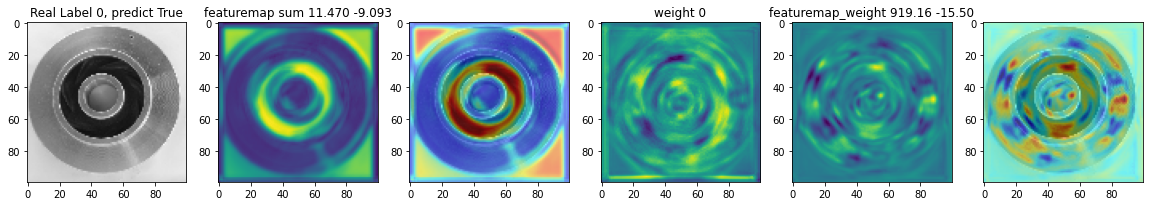

In [72]:
plt.figure(figsize=(20,20))
plt.subplot(1,6,1)
plt.title("Real Label "+str(label)+", predict "+str(y==label))
plt.imshow(img/np.amax(img))

bn = feature_activation[key].cpu()[0].numpy()
bn_sum = bn.sum(axis=0)
plt.subplot(1,6,2)
plt.title("featuremap sum "+str(format(np.amax(bn_sum),'.3f'))+" "+str(format(np.amin(bn_sum),'.3f')))
plt.imshow(bn_sum)

bn_norm = cv2.normalize(bn_sum, None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
cam = show_cam_on_image(img, bn_norm, use_rgb=True)
plt.subplot(1,6,3)
plt.imshow(cam)

weight = params_last[label].numpy()
weight_sum = weight.sum(axis=0)
plt.subplot(1,6,4)
plt.title("weight "+str(label))
plt.imshow(weight_sum)

bn_weight = cv2.multiply(bn, weight).sum(axis=0)
plt.subplot(1,6,5)
plt.title("featuremap_weight "+str(i)+str(format(np.amax(bn_weight),'.2f'))+" "+str(format(np.amin(bn_weight),'.2f')))
plt.imshow(bn_weight)

bn_weight_norm = cv2.normalize(bn_weight, None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
cam = show_cam_on_image(img, bn_weight_norm, use_rgb=True)
plt.subplot(1,6,6)
plt.imshow(cam)

plt.show()

In [74]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

pre_layer.0  :  torch.Size([1, 64, 100, 100])
pre_layer.1  :  torch.Size([1, 64, 100, 100])
pre_layer  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.0  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.1  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.2  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.3  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.4  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.5  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.6  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.7  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock  :  torch.Size([1, 64, 100, 100])
residual_layer.0  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.0  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.1  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.2  :  torch.Size([1, 64, 100, 100])
residual_la

# 04. GradCAM

In [86]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image

def gradcams(model,input_tensor,target_layers,img,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor,targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    grayscale_cam = cv2.normalize(grayscale_cam, None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
    gb = cv2.normalize(gb, None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)

    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cv2.normalize(cam_mask*gb, None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
    
    return visualization,gb,cam_gb,cam_mask

Real Label 0, predict True


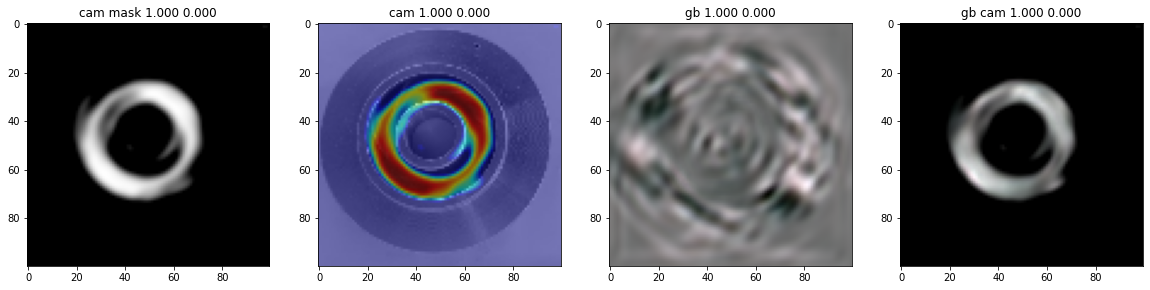

In [88]:
target_layers = [model.residual_layer]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
print("Real Label "+str(label)+", predict "+str(y==label))
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.title("cam mask "+str(format(np.amax(cam),'.3f'))+" "+str(format(np.amin(cam),'.3f')))
plt.imshow(cam)
plt.subplot(1,4,2)
plt.title("cam "+str(format(np.amax(cam),'.3f'))+" "+str(format(np.amin(cam),'.3f')))
plt.imshow(visualization)
plt.subplot(1,4,3)
plt.imshow(gb)
plt.title("gb "+str(format(np.amax(cam),'.3f'))+" "+str(format(np.amin(cam),'.3f')))
plt.subplot(1,4,4)
plt.title("gb cam "+str(format(np.amax(cam),'.3f'))+" "+str(format(np.amin(cam),'.3f')))
plt.imshow(cam_gb)

# 05. Deconvlution

In [55]:
class ConvTrans(nn.Module):
    def __init__(self, image_size):
        super(ConvTrans,self).__init__()
        self.image_size = image_size
        
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2),
            nn.ReLU()
        )
    
    def forward(self, input_image):
        output = self.layer(input_image)
        return output

In [59]:
model_trans = ConvTrans

In [61]:
image_size = 100
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model_trans(test_input))

ConvTrans(
  (layer): Sequential(
    (0): ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
)


# 99. save model

In [89]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model,"def_allweight_220929.pkl")

AttributeError: Can't pickle local object 'get_activation.<locals>.hook'